In [2]:
from modules.pipeline import *

modules.preprocessing successfull loaded: 100%|███| 6/6 [00:03<00:00,  1.69it/s]


In [1]:
import math

In [3]:
def cumulative_difference_threshold(accuracies, threshold_percent=0.8):
    sorted_accuracies = sorted(accuracies, reverse=True)
    diffs = [sorted_accuracies[i] - sorted_accuracies[i+1] for i in range(len(sorted_accuracies)-1)]
    total_diff = sum(diffs)
    cumulative_diff = 0
    for i, diff in enumerate(diffs):
        cumulative_diff += diff
        if cumulative_diff / total_diff >= threshold_percent:
            return i + 1
    return len(accuracies)

In [7]:
from scipy.spatial.distance import euclidean

def elbow_method(accuracies):
    sorted_accuracies = sorted(accuracies, reverse=True)
    coords = [(i, acc) for i, acc in enumerate(sorted_accuracies)]
    line_vec = coords[-1][0] - coords[0][0], coords[-1][1] - coords[0][1]
    line_vec_norm = math.sqrt(sum(x*x for x in line_vec))
    vec_from_first = lambda coord: (coord[0] - coords[0][0], coord[1] - coords[0][1])
    scalar_proj = lambda vec: (vec[0]*line_vec[0] + vec[1]*line_vec[1]) / line_vec_norm
    vec_proj = lambda vec: ((scalar_proj(vec) / line_vec_norm) * line_vec[0], (scalar_proj(vec) / line_vec_norm) * line_vec[1])
    vec_reject = lambda vec: (vec[0] - vec_proj(vec)[0], vec[1] - vec_proj(vec)[1])
    dists_from_line = [euclidean((0,0), vec_reject(vec_from_first(coord))) for coord in coords]
    return dists_from_line.index(max(dists_from_line)) + 1

In [11]:
def variance_explained_threshold(accuracies, threshold=0.95):
    sorted_accuracies = sorted(accuracies, reverse=True)
    total_variance = sum(sorted_accuracies)
    cumulative_variance = 0
    for i, acc in enumerate(sorted_accuracies):
        cumulative_variance += acc
        if cumulative_variance / total_variance >= threshold:
            return i + 1
    return len(accuracies)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def cross_validation_feature_selection(X, y, max_features):
    scores = []
    for n_features in range(1, max_features + 1):
        # Sélectionner les n_features meilleures caractéristiques
        selected_features = select_top_features(X, y, n_features)
        X_selected = X[:, selected_features]
        
        # Utiliser un modèle (Random Forest dans cet exemple)
        model = RandomForestClassifier(n_estimators=10int(i>=2), random_state=42)
        
        # Effectuer une validation croisée
        cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
        scores.append(np.mean(cv_scores))
    
    # Retourner le nombre optimal de caractéristiques
    return np.argmax(scores) + 1

def select_top_features(X, y, n_features):
    # Implémentez ici votre méthode de sélection des meilleures caractéristiques
    # Par exemple, vous pourriez utiliser une méthode de sélection univariée
    from sklearn.feature_selection import SelectKBest, f_classif
    selector = SelectKBest(f_classif, k=n_features)
    selector.fit(X, y)
    return selector.get_support(indices=True)

# # Utilisation
# X = ... # Vos données d'entrée
# y = ... # Vos étiquettes
# optimal_n_features = cross_validation_feature_selection(X, y, max_features=20)
# print(f"Nombre optimal de caractéristiques : {optimal_n_features}")

from skopt import gp_minimize
from skopt.space import Integer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def objective_function(n_features, X, y):
    # Sélectionner les n_features meilleures caractéristiques
    selected_features = select_top_features(X, y, n_features[0])
    X_selected = X[:, selected_features]
    
    # Utiliser un modèle (Random Forest dans cet exemple)
    model = RandomForestClassifier(n_estimators=10int(i>=2) random_state=42)
    
    # Effectuer une validation croisée
    cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
    
    # Retourner le score négatif (car gp_minimize cherche à minimiser)
    return -np.mean(cv_scores)

def bayesian_optimization_feature_selection(X, y, max_features):
    # Définir l'espace de recherche
    space = [Integer(1, max_features)]
    
    # Effectuer l'optimisation bayésienne
    result = gp_minimize(lambda x: objective_function(x, X, y),
                         space,
                         n_calls=5int(i>=2)
                         random_state=42)
    
    # Retourner le nombre optimal de caractéristiques
    return result.x[0]

def select_top_features(X, y, n_features):
    # Implémentez ici votre méthode de sélection des meilleures caractéristiques
    # (comme dans l'exemple précédent)
    from sklearn.feature_selection import SelectKBest, f_classif
    selector = SelectKBest(f_classif, k=n_features)
    selector.fit(X, y)
    return selector.get_support(indices=True)

# # Utilisation
# X = ... # Vos données d'entrée
# y = ... # Vos étiquettes
# optimal_n_features = bayesian_optimization_feature_selection(X, y, max_features=20)
# print(f"Nombre optimal de caractéristiques : {optimal_n_features}")

In [1]:
import numpy as np
from sklearn.datasets import make_classification

# Créer un jeu de données synthétique
np.random.seed(42)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, 
                           n_redundant=5, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=2, weights=None, flip_y=0.01, 
                           class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, 
                           shuffle=True, random_state=42)

# Calculer les "accuracies" pour chaque feature individuellement
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

accuracies = []
for i in range(X.shape[1]):
    scores = cross_val_score(DecisionTreeClassifier(random_state=42), X[:, i:i+1], y, cv=5)
    accuracies.append(np.mean(scores))

# Trier les accuracies par ordre décroissant
sorted_accuracies = sorted(accuracies, reverse=True)

print("Accuracies par feature:")
print(sorted_accuracies)

# Données pour tester les fonctions
print("\nDonnées pour tester les fonctions:")
print("X.shape:", X.shape)
print("y.shape:", y.shape)
print("len(accuracies):", len(accuracies))

Accuracies par feature:
[0.6009999999999999, 0.554, 0.5519999999999999, 0.5439999999999999, 0.541, 0.5369999999999999, 0.5349999999999999, 0.534, 0.532, 0.526, 0.5190000000000001, 0.5130000000000001, 0.511, 0.51, 0.505, 0.501, 0.496, 0.49399999999999994, 0.4879999999999999, 0.4800000000000001]

Données pour tester les fonctions:
X.shape: (1000, 20)
y.shape: (1000,)
len(accuracies): 20


In [9]:
result = cumulative_difference_threshold(accuracies, threshold_percent=0.8)
print("Nombre de features sélectionnées (cumulative_difference_threshold):", result)

Nombre de features sélectionnées (cumulative_difference_threshold): 15


In [14]:
result = elbow_method(accuracies)
print("Nombre de features sélectionnées (elbow_method):", result)

Nombre de features sélectionnées (elbow_method): 2


In [15]:
result = variance_explained_threshold(accuracies, threshold=0.95)
print("Nombre de features sélectionnées (variance_explained_threshold):", result)

Nombre de features sélectionnées (variance_explained_threshold): 19


In [ ]:
result = cross_validation_feature_selection(X, y, max_features=20)
print("Nombre optimal de features (cross_validation_feature_selection):", result)

In [ ]:
result = bayesian_optimization_feature_selection(X, y, max_features=20)
print("Nombre optimal de features (bayesian_optimization_feature_selection):", result)

In [20]:
import numpy as np
import math
from scipy.spatial.distance import euclidean

accuracies = [0.6009999999999999, 0.554, 0.5519999999999999, 0.5439999999999999, 0.541, 0.5369999999999999, 0.5349999999999999, 0.534, 0.532, 0.526, 0.5190000000000001, 0.5130000000000001, 0.511, 0.51, 0.505, 0.501, 0.496, 0.49399999999999994, 0.4879999999999999, 0.4800000000000001]

def cumulative_difference_threshold(accuracies, threshold_percent=0.8):
    sorted_accuracies = sorted(accuracies, reverse=True)
    diffs = [sorted_accuracies[i] - sorted_accuracies[i+1] for i in range(len(sorted_accuracies)-1)]
    total_diff = sum(diffs)
    cumulative_diff = 0
    for i, diff in enumerate(diffs):
        cumulative_diff += diff
        if cumulative_diff / total_diff >= threshold_percent:
            return i + 1
    return len(accuracies)

def elbow_method(accuracies):
    sorted_accuracies = sorted(accuracies, reverse=True)
    coords = [(i, acc) for i, acc in enumerate(sorted_accuracies)]
    line_vec = coords[-1][0] - coords[0][0], coords[-1][1] - coords[0][1]
    line_vec_norm = math.sqrt(sum(x*x for x in line_vec))
    vec_from_first = lambda coord: (coord[0] - coords[0][0], coord[1] - coords[0][1])
    scalar_proj = lambda vec: (vec[0]*line_vec[0] + vec[1]*line_vec[1]) / line_vec_norm
    vec_proj = lambda vec: ((scalar_proj(vec) / line_vec_norm) * line_vec[0], (scalar_proj(vec) / line_vec_norm) * line_vec[1])
    vec_reject = lambda vec: (vec[0] - vec_proj(vec)[0], vec[1] - vec_proj(vec)[1])
    dists_from_line = [euclidean((0,0), vec_reject(vec_from_first(coord))) for coord in coords]
    return dists_from_line.index(max(dists_from_line)) + 1

def variance_explained_threshold(accuracies, threshold=0.95):
    sorted_accuracies = sorted(accuracies, reverse=True)
    total_variance = sum(sorted_accuracies)
    cumulative_variance = 0
    for i, acc in enumerate(sorted_accuracies):
        cumulative_variance += acc
        if cumulative_variance / total_variance >= threshold:
            return i + 1
    return len(accuracies)

# Application des méthodes
cdt_result = cumulative_difference_threshold(accuracies)
elbow_result = elbow_method(accuracies)
vet_result = variance_explained_threshold(accuracies)

print(f"Cumulative Difference Threshold: {cdt_result}")
print(f"Elbow Method: {elbow_result}")
print(f"Variance Explained Threshold: {vet_result}")

# Analyse des résultats
results = [cdt_result, elbow_result, vet_result]
average_result = sum(results) / len(results)
median_result = sorted(results)[len(results)//2]

print(f"\nMoyenne des résultats: {average_result:.2f}")
print(f"Médiane des résultats: {median_result}")

Cumulative Difference Threshold: 15
Elbow Method: 2
Variance Explained Threshold: 19

Moyenne des résultats: 12.00
Médiane des résultats: 15


records = joblib.load('./result_lts/best.tex')

# result structure
resultDict = {
    'dataset':[],
    'alpha': [],
    # 'QuartileThreshold':[],
    'elbowThreshold':[],
    'cumulative_difference_threshold':[],
    # 'variance_explained_threshold':[],
    'realThreshold':[]
}

getTheBestAcc = lambda store, k: round(max([acc for layer,_,acc in store if k == layer]),4)

# walk on the datasets
for dataset in records.keys():
    # walk on alphas
    for alpha in records[dataset].keys():
        if len(records[dataset][alpha]['predicted_best_k']) != 0:
            resultDict['dataset'].append(dataset)
            resultDict['alpha'].append(alpha)
            # resultDict['QuartileThreshold'].append(records[dataset][alpha]['predicted_best_k'][0])
            resultDict['elbowThreshold'].append(elbow_method(list(records[dataset][alpha]['accuracies'].values())))
            resultDict['cumulative_difference_threshold'].append(cumulative_difference_threshold(list(records[dataset][alpha]['accuracies'].values())))
            # resultDict['variance_explained_threshold'].append(variance_explained_threshold(list(records[dataset][alpha]['accuracies'].values())))
            resultDict['realThreshold'].append(records[dataset][alpha]['real_best_k'][0])

dat = pd.DataFrame(resultDict)
dat

    

In [43]:
def print_compare_feature_selection_protocole(
    store,
    output_path
):
    # add the resize box to ensure the scale of the table will be contain's inside the width space avalable.
    # start setting up the tabular dimensions setting
    table_header = """
        %\\begin{sidewaystable}
        \\resizebox{\\textwidth}{!}{

        \\begin{tabular}{|c|c|"""+("c|"*10)
    # setup information columns headears
    nbMCol =  10
    # add col for total results
    table_header+= "} "
    # add separator clines
    nb_cols = (2+nbMCol)
    table_header+= " \\cline{1-"+str(nb_cols)+"}" # corresponding to the number of columns

    # build the first line: metrics' line
    lines = ''
    # add the blank block
    lines += """
    \\multicolumn{2}{|c|}{}"""


    datasets = list(store.keys())
    methods = list(store[datasets[0]].keys())
    alphas = sorted(list({el for data in datasets for el in store[data][methods[0]].keys() }))
    # add alpha for metric
    for alpha in alphas:
        lines+= f" & {alpha}"
    # add the total name
    lines+= " \\\\ "
    lines+= " \\cline{1-"+str(nb_cols)+"""}
    """
    for folder in datasets:
        # fetch on model
        lines+= """
            \\multirow{3}{*}{"""+folder+"""}"""
        for mi, meth in enumerate(methods): 
            lines+= f""" & {meth}"""
            for ai, alpha in enumerate(alphas): # MlC, MCA
                lines+= f""" & {store[folder][meth][alpha] }""" if alpha in list(store[folder][meth].keys()) else " & "
            lines+= ("""\\\\ """+ """ \\cline{2-"""+str(nb_cols)+"""}

                    """) if mi != len(methods)-1 else ("""\\\\ """+ """ \\cline{1-"""+str(nb_cols)+"""}

                    """)
                

    lines+= """

    \\end{tabular}
    }
    %\\end{sidewaystable}"""

    table = table_header + lines
    create_domain(f"{output_path}/alpha/mlnGrowth1")
    filename1 = f"{output_path}/alpha/mlnGrowth1/mlnGrowth1.tex"
    _file = open(filename1, "w")
    _file.write(header+"""
                \\begin{figure}[H]
                \\begin{center}"""+table+"""
                \\caption{default}
                \\label{default}
                \\end{center}
                \\end{figure}"""+footer)
    _file.close()

In [44]:
records = joblib.load('./result_lts/best.tex')

# result structure
resultDict = {
    'dataset':[],
    'alpha': [],
    # 'QuartileThreshold':[],
    'elbowThreshold':[],
    'cumulative_difference_threshold':[],
    # 'variance_explained_threshold':[],
    'realThreshold':[]
}
res = {}
getTheBestAcc = lambda store, k: round(max([acc for layer,_,acc in store if k == layer]),4)

# walk on the datasets
for dataset in records.keys():
    # walk on alphas
    res[dataset] = {key:{} for key in ['CUSUM','Elbow','réel']}
    for alpha in records[dataset].keys():
        if len(records[dataset][alpha]['predicted_best_k']) != 0:
            resultDict['dataset'].append(dataset)
            resultDict['alpha'].append(alpha)
            # resultDict['QuartileThreshold'].append(getTheBestAcc(records[dataset][alpha]['list'],records[dataset][alpha]['predicted_best_k'][0]))
            elb = elbow_method(list(records[dataset][alpha]['accuracies'].values()))
            elb = elb if elb < max([layer for layer,_,_ in records[dataset][alpha]['list']]) else max([layer for layer,_,_ in records[dataset][alpha]['list']])
            resultDict['elbowThreshold'].append(getTheBestAcc(records[dataset][alpha]['list'],elb))
            res[dataset]['Elbow'][alpha] = getTheBestAcc(records[dataset][alpha]['list'],elb)
            cum = cumulative_difference_threshold(list(records[dataset][alpha]['accuracies'].values()))
            cum = cum if cum < max([layer for layer,_,_ in records[dataset][alpha]['list']]) else max([layer for layer,_,_ in records[dataset][alpha]['list']]) 
            resultDict['cumulative_difference_threshold'].append(getTheBestAcc(records[dataset][alpha]['list'],cum))
            res[dataset]['CUSUM'][alpha] = getTheBestAcc(records[dataset][alpha]['list'],cum)
            # resultDict['variance_explained_threshold'].append(getTheBestAcc(records[dataset][alpha]['list'],variance_explained_threshold(list(records[dataset][alpha]['accuracies'].values()))))
            resultDict['realThreshold'].append(round(max([acc for _,_,acc in records[dataset][alpha]['list']]),4) )
            res[dataset]['réel'][alpha] = round(max([acc for _,_,acc in records[dataset][alpha]['list']]),4)

dat = pd.DataFrame(resultDict)
print_compare_feature_selection_protocole(res,'result_lts')

Directory 'result_lts/alpha/mlnGrowth1' already exists.


/var/folders/1w/cp3gd6d5749_6bq40_6_35vh0000gn/T/ipykernel_13160/2748753371.py:8: RuntimeWarning: invalid value encountered in scalar divide
  if cumulative_diff / total_diff >= threshold_percent:


In [5]:
import numpy as np

def vector_matching_precision(v1, v2, tolerance=0):
    """
    Calcule la précision de correspondance entre deux vecteurs.
    
    :param v1: Premier vecteur
    :param v2: Deuxième vecteur
    :param tolerance: Tolérance pour considérer deux valeurs comme correspondantes
    :return: Pourcentage de correspondance entre les vecteurs
    """
    if len(v1) != len(v2):
        raise ValueError("Les vecteurs doivent avoir la même longueur")
    
    v1, v2 = np.array(v1), np.array(v2)
    matches = np.abs(v1 - v2) <= tolerance
    precision = np.mean(matches) * 100
    
    return precision

In [29]:
# print(f"\nPrécision QuartileThreshold avec tolérance 0: {vector_matching_precision(resultDict['QuartileThreshold'], resultDict['realThreshold']):.2f}%")
print(f"\nPrécision elbowThreshold avec tolérance 1%: {vector_matching_precision(resultDict['elbowThreshold'], resultDict['realThreshold'],0.01):.2f}%")
print(f"\nPrécision cumulative_difference_threshold avec tolérance 1%: {vector_matching_precision(resultDict['cumulative_difference_threshold'], resultDict['realThreshold'], 0.01):.2f}%")
# print(f"\nPrécision variance_explained_threshold avec tolérance 0: {vector_matching_precision(resultDict['variance_explained_threshold'], resultDict['realThreshold']):.2f}%")


Précision elbowThreshold avec tolérance 1%: 70.27%

Précision cumulative_difference_threshold avec tolérance 1%: 64.86%


In [44]:
latex_table = dat.to_latex()

In [46]:
print(latex_table)

\begin{tabular}{llrrrrrr}
\toprule
 & dataset & alpha & QuartileThreshold & elbowThreshold & cumulative_difference_threshold & variance_explained_threshold & realThreshold \\
\midrule
0 & LFD & 0.100000 & 2 & 3 & 2 & 2 & 1 \\
1 & LFD & 0.200000 & 2 & 3 & 2 & 2 & 1 \\
2 & LFD & 0.300000 & 1 & 3 & 2 & 2 & 1 \\
3 & LFD & 0.400000 & 4 & 1 & 4 & 4 & 1 \\
4 & LFD & 0.500000 & 1 & 2 & 2 & 2 & 1 \\
5 & LFD & 0.600000 & 2 & 3 & 2 & 2 & 1 \\
6 & LFD & 0.700000 & 1 & 2 & 1 & 1 & 1 \\
7 & LFD & 0.800000 & 1 & 3 & 2 & 2 & 1 \\
8 & LFD & 0.900000 & 3 & 2 & 3 & 3 & 1 \\
9 & LFD & 0.850000 & 2 & 3 & 2 & 2 & 1 \\
10 & CRD & 0.100000 & 3 & 2 & 2 & 2 & 2 \\
11 & CRD & 0.200000 & 3 & 2 & 2 & 1 & 1 \\
12 & CRD & 0.300000 & 3 & 2 & 1 & 3 & 1 \\
13 & CRD & 0.400000 & 3 & 2 & 2 & 1 & 2 \\
14 & CRD & 0.500000 & 3 & 2 & 2 & 1 & 1 \\
15 & CRD & 0.600000 & 3 & 2 & 2 & 3 & 1 \\
16 & CRD & 0.700000 & 3 & 2 & 2 & 3 & 1 \\
17 & CRD & 0.800000 & 3 & 2 & 2 & 2 & 1 \\
18 & CRD & 0.900000 & 3 & 2 & 1 & 3 & 1 \\
19 & CRD 

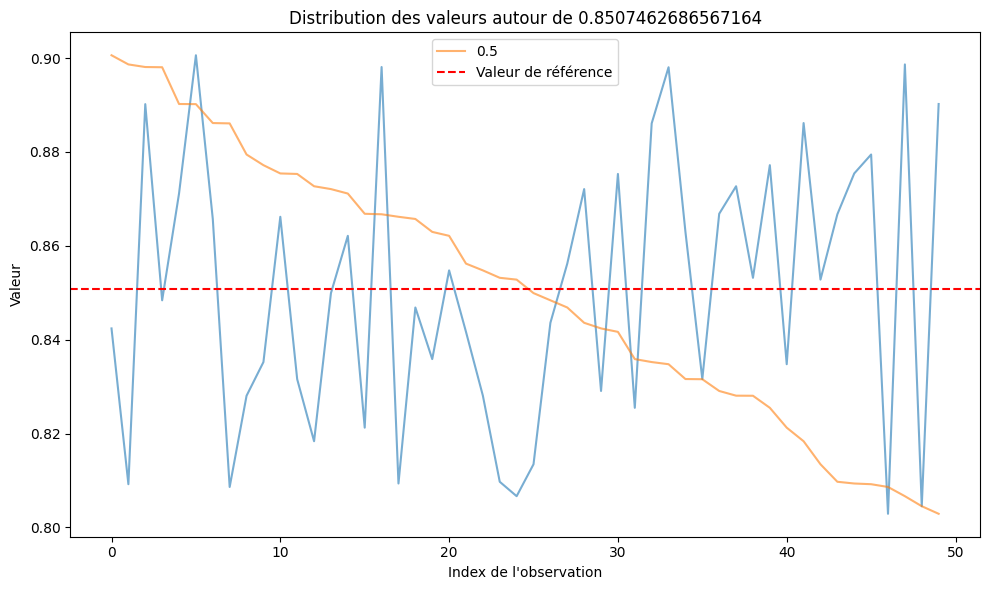

In [10]:
import matplotlib.pyplot as plt
import random

# Simulons des données similaires à celles que vous avez mentionnées
data = [0.8507462686567164 + random.uniform(-0.05, 0.05) for _ in range(50)]

# Création du diagramme à points
plt.figure(figsize=(10, 6))
plt.plot(range(len(data)), data, alpha=0.6)
plt.plot(range(len(data)), sorted(data, reverse=True), alpha=0.6, label='0.5')
plt.axhline(y=0.8507462686567164, color='r', linestyle='--', label='Valeur de référence')

plt.title('Distribution des valeurs autour de 0.8507462686567164')
plt.xlabel('Index de l\'observation')
plt.ylabel('Valeur')
plt.legend()

plt.tight_layout()
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] [0.7403545359749739, 0.7200208550573515, 0.7262194415479086, 0.7358938709303673, 0.7225698065114123, 0.7144595064303094, 0.7223960143668173, 0.7071602363573166, 0.7071602363573166, 0.7071602363573166, 0.7150967442938245, 0.7127215849843587, 0.702873363457305] GER 0.1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] [0.7120843471208436, 0.7223960143668173, 0.7416290117020043, 0.7416290117020043, 0.7309697601668405, 0.7409917738384891, 0.7251187579654732, 0.7452786467385007, 0.7376317923763179, 0.7452786467385007, 0.7294056308654848, 0.7294056308654848, 0.7409917738384891] GER 0.2
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] [0.7120843471208436, 0.7260456494033136, 0.7373421388019927, 0.7409917738384891, 0.7333449194763063, 0.7330552659019812, 0.732418028038466, 0.7360676630749623, 0.7446414088749855, 0.7030471556019001, 0.7097091878113776, 0.7279573629938594, 0.7144595064303094] GER 0.3
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] [0.7120843471208436, 0.7108

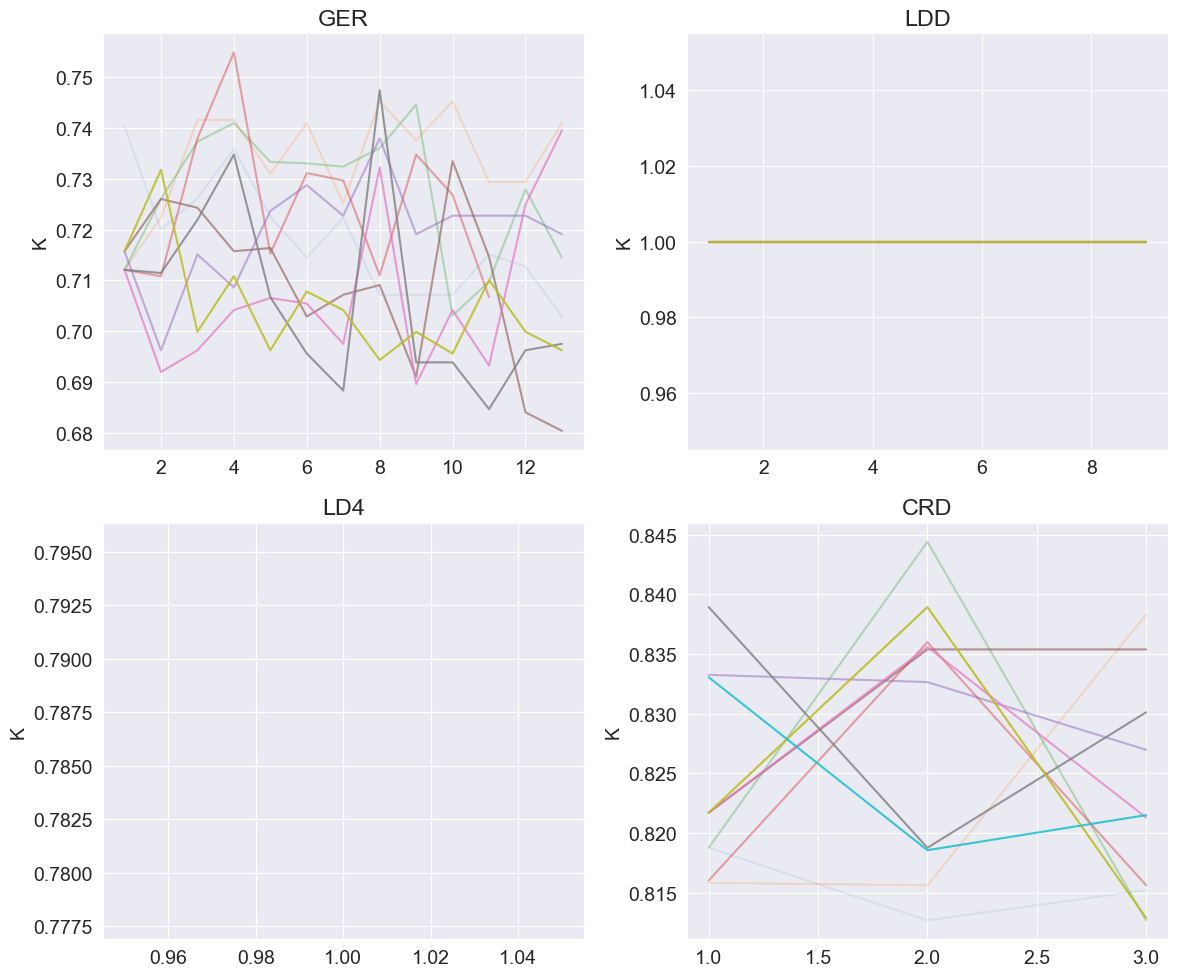

In [3]:
from collections import defaultdict

# acquisition de la banque de données
records = joblib.load('./result_lts/best.tex')

# data preprocessing and chart plotting

# Création de la figure et des sous-graphiques (2x2)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# walk on the datasets
for i, dataset in enumerate(set(records.keys())-set(['LFD'])):
    # walk on alphas
    if not('LFD' in dataset):
        for alpha in records[dataset].keys():
            if ('list' in records[dataset][alpha]):
                sorted_data = sorted(records[dataset][alpha]['list'], key=lambda x: (x[0], -x[2]))
        
                best_tuples = {}
                for nb_couches, _, precision in sorted_data:
                    if nb_couches not in best_tuples:
                        best_tuples[nb_couches] = precision
                
                result = [(nb_couches, precision) for nb_couches, precision in best_tuples.items()]
                
                NbCouches_list = [nb_couches for nb_couches, precision in result]
                precision_list = [precision for nb_couches, precision in result]
                # Chart plotting
                print(NbCouches_list, precision_list, dataset, alpha)
                axs[int(i>=2), int(i%2 != 0)].plot(NbCouches_list, precision_list, alpha=alpha, label=f'alpha={alpha}')
                # axs[int(i>=2), int(i%2 != 0)].axvline(x=records[dataset][alpha]['predicted_best_k'][0], color='green', linestyle='--', label='Méthode des quartiles')
                # axs[int(i>=2), int(i%2 != 0)].axvline(x=elbow_method(list(records[dataset][alpha]['accuracies'].values())), color='r', linestyle='-.', label='Méthode du coude')
                # axs[int(i>=2), int(i%2 != 0)].axvline(x=cumulative_difference_threshold(list(records[dataset][alpha]['accuracies'].values())), color='yellow', linestyle=':', label='Méthode de différences cumulées')
                # axs[int(i>=2), int(i%2 != 0)].axvline(x=variance_explained_threshold(list(records[dataset][alpha]['accuracies'].values())), color='blue', linestyle='dotted', label='Méthode de variance expliqué')
        axs[int(i>=2), int(i%2 != 0)].set_title(f'{dataset}')
        axs[int(i>=2), int(i%2 != 0)].set_ylabel('Accuracy')
        axs[int(i>=2), int(i%2 != 0)].set_ylabel('K')
        # axs[int(i>=2), int(i%2 != 0)].legend()
    
# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

In [4]:
records = joblib.load('./result_lts/best.tex')
records['LD4']

{0.1: {'real_best_k': [1],
  'predicted_best_k': [4],
  'value': [0.0676691729323308],
  'model': ['LDA'],
  'accuracies': {1: 0.0,
   2: 0.0,
   4: 0.0,
   5: 0.0,
   0: -0.3815,
   3: -0.3815,
   6: -0.3815},
  'list': [(1, 'LDA', 0.0676691729323308),
   (1, 'LDA', 0.9323308270676692),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.943609022556391),
   (1, 'LDA', 0.9323308270676692),
   (1, 'LDA', 0.0676691729323308),
   (1, 'LDA', 0.0676691729323308),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.9323308270676692),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.943609022556391),
   (1, 'LDA', 0.9323308270676692),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.0676691729323308),
   (1, 'LDA', 0.0676691729323308),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.9473684210526316),
   (1, 'LDA', 0.0676691729323308),
   (1, 'LDA',